In [1]:
from operator import index
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import jax.numpy as jnp # ai-accelerator agnostic numpy implementations
import jax # autograd + XLA
import tensorflow_probability as tfp # tensorflow probability
import seaborn as sns
import warnings
from kernel import kernel_functions, preprocess
warnings.filterwarnings("ignore")

In [3]:
np.multiply([1,2,3],[4,5,6])
H = []
H[0] =2


IndexError: list assignment index out of range

In [2]:
tfd = tfp.distributions

In [3]:
n = tfd.Normal(loc = 0., scale = 1.)

2022-09-25 09:51:18.140960: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 09:51:18.705351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-09-25 09:51:18.705442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/l

In [17]:
to_plot = n.sample(600)

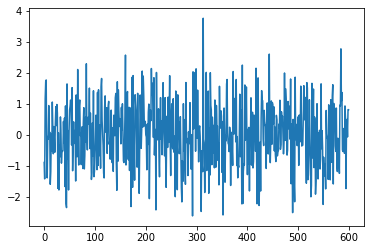

In [18]:
plt.plot(to_plot)

In [19]:
to_plot_list = []
start = float(n.sample(1))
to_plot_list.append(start)


In [20]:
to_plot_list

[0.24865177273750305]

In [23]:

for _ in range(600):
    new_normal = tfd.Normal(loc = to_plot_list[_], scale = 1)
    to_plot_list.append(float(new_normal.sample(1)))

In [24]:
to_plot_list

[0.24865177273750305,
 -0.2671063244342804,
 -1.3039103746414185,
 -1.0365921258926392,
 -1.0799123048782349,
 -1.6533308029174805,
 0.5059506893157959,
 1.0441875457763672,
 1.5305595397949219,
 2.4215097427368164,
 1.0151017904281616,
 0.8387826085090637,
 0.9350195527076721,
 2.64746356010437,
 2.6187808513641357,
 3.0080463886260986,
 2.7020843029022217,
 2.124654531478882,
 2.5578551292419434,
 2.275736093521118,
 2.3622050285339355,
 1.5630608797073364,
 1.2461800575256348,
 3.2232460975646973,
 5.006570339202881,
 6.289637088775635,
 5.29604434967041,
 5.120377063751221,
 4.483451843261719,
 6.1926727294921875,
 4.718479156494141,
 3.9013915061950684,
 3.9837934970855713,
 3.735952138900757,
 4.548919200897217,
 5.99458122253418,
 4.6400146484375,
 3.4570460319519043,
 2.1091747283935547,
 1.839054822921753,
 1.6889344453811646,
 1.0405659675598145,
 1.5829808712005615,
 3.249856948852539,
 2.573171615600586,
 2.714733600616455,
 2.698695659637451,
 1.2158870697021484,
 0.831299

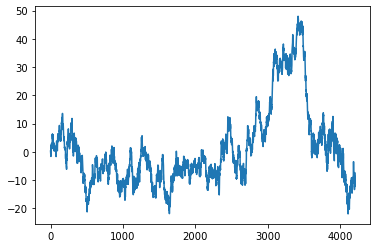

In [25]:
plt.plot(to_plot_list)

# Algorithm for GP Regression

- $ L $ = cholesky $(K + \sigma^2 I)$  
    $K$ is your "variance", and then you add jitter, take square-root.
- $ \alpha = L^{T} \dot (L \dot y)
- 

In [2]:
import numpy as np
def generate_noisy_points(n=10, noise_variance=1e-6):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y

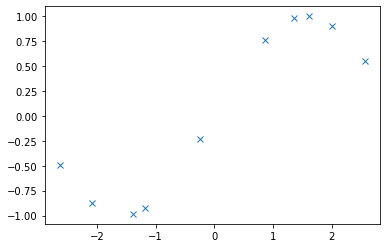

In [3]:
import matplotlib.pylab as plt
X, y = generate_noisy_points()
plt.plot(X, y, 'x')
plt.show()

In [4]:
Xtest, ytest = generate_noisy_points(100)
Xtest.sort(axis=0)

In [5]:
Xtest

array([[-2.95566929],
       [-2.9201397 ],
       [-2.90199351],
       [-2.83834644],
       [-2.82330852],
       [-2.7429149 ],
       [-2.62778151],
       [-2.52188469],
       [-2.45276658],
       [-2.43976046],
       [-2.43688993],
       [-2.41783858],
       [-2.30850193],
       [-2.26288982],
       [-2.2108031 ],
       [-2.08401759],
       [-1.92041816],
       [-1.8813444 ],
       [-1.85021381],
       [-1.84102557],
       [-1.78489918],
       [-1.66243141],
       [-1.64777028],
       [-1.48128633],
       [-1.38683965],
       [-1.3847696 ],
       [-1.27395814],
       [-1.22476384],
       [-1.21890601],
       [-1.19011026],
       [-1.18586034],
       [-1.13203617],
       [-1.10926932],
       [-1.04046712],
       [-1.03162782],
       [-0.9824503 ],
       [-0.93995677],
       [-0.93474664],
       [-0.87537925],
       [-0.82599833],
       [-0.76044368],
       [-0.65611144],
       [-0.6013361 ],
       [-0.50851386],
       [-0.45406806],
       [-0

In [6]:
def rbf_kernel(x_a: float, x_b: float, sigma = 0.4):
        """
        The covariance function k(x_a, x_b) models the joint variability of
        the Gaussian Process random variables. Here, we take it as the 
        exponentiated quadratic covariance function, called the RBF kernel.
        """

        return jnp.exp(-0.5/sigma*(sp.spatial.distance.cdist(x_a, x_b, "sqeuclidean")))
        # Squared euclidean distance, taken pairwise across all elements of x_a and x_b.

In [7]:
def jitter_matrix(dim_count: int, value = 1e-5):
        """
        Add jitter along diagonals to make sure matrix doesn't become singular.
        Reduces overfitting in many huge-input cases.
        """

        return jnp.eye(dim_count) * value

In [8]:
n = len(Xtest)
K = rbf_kernel(Xtest, Xtest)
L = np.linalg.cholesky(K + jitter_matrix(dim_count= n))
f_prior = np.dot(L, np.random.normal(size=(n, 10)))

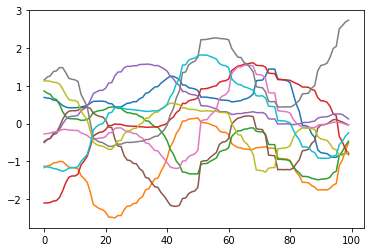

In [9]:
plt.plot(f_prior)

In [10]:
f_prior[0]

array([ 0.69213665, -1.17133766,  0.86167662, -2.10678536, -0.47074229,
       -0.50278177, -0.27729982,  1.15709006,  1.13110768, -1.12820783])

In [11]:
N, n = len(X), len(Xtest)
K = rbf_kernel(X, X)
L = np.linalg.cholesky(K + jitter_matrix(dim_count= N))
K_ = rbf_kernel(Xtest, Xtest)
Lk = np.linalg.solve(L, rbf_kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))
L = np.linalg.cholesky(K_ + jitter_matrix(dim_count= n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))


In [12]:
def gaussian_prior(x_test, sample_count = 50,):

    K = rbf_kernel(x_test, x_test) 
    # The Kernel function applied over itself resembles the variance of the distribution.
    L = jnp.linalg.cholesky(K + preprocess.jitter_matrix(len(x_test)))
    # The Cholesky Decomposition essentially gives the square-root of the matrix, so from variance to SD.
    gp_prior = jnp.dot(L, np.random.normal(size = (len(x_test), sample_count)))
    # Sample the 

    return gp_prior

In [13]:
gp_prior = gaussian_prior(Xtest)

In [16]:
f_post = gaussian_posterior(gp_prior, X, y)

In [15]:
def gaussian_posterior(gp_prior, X_data, Y_data):
    N, n = len(X_data), len(gp_prior)
    X_test = jnp.linspace(start = min(X_data), stop = max(X_data), num = len(gp_prior))
    K = rbf_kernel(X_data, X_data)
    L = np.linalg.cholesky(K + preprocess.jitter_matrix(dim_count= N))
    K_ = rbf_kernel(X_test, X_test)
    Lk = np.linalg.solve(L, rbf_kernel(X_data, X_test))
    mu = np.dot(Lk.T, np.linalg.solve(L, y))
    L = np.linalg.cholesky(K_ + preprocess.jitter_matrix(dim_count= n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))

    return f_post

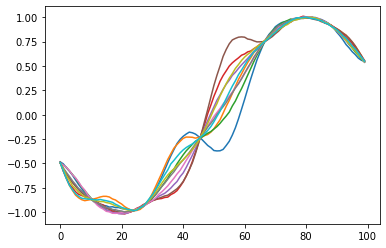

In [18]:
plt.plot(f_post)

In [19]:
mu

array([[-0.25786137],
       [-0.27989223],
       [-0.29151682],
       [-0.33415406],
       [-0.34462377],
       [-0.40280768],
       [-0.49095523],
       [-0.57416933],
       [-0.6280237 ],
       [-0.63802616],
       [-0.64022645],
       [-0.65475593],
       [-0.73490293],
       [-0.76623091],
       [-0.80012743],
       [-0.87291292],
       [-0.94369349],
       [-0.95651834],
       [-0.9655993 ],
       [-0.96808709],
       [-0.98138727],
       [-0.99921256],
       [-1.00032963],
       [-0.99797113],
       [-0.98437972],
       [-0.98398228],
       [-0.95645141],
       [-0.94029368],
       [-0.938209  ],
       [-0.9274664 ],
       [-0.92581148],
       [-0.90331877],
       [-0.89295783],
       [-0.85866117],
       [-0.85393675],
       [-0.82637426],
       [-0.80087053],
       [-0.79763975],
       [-0.75929932],
       [-0.72538991],
       [-0.67781829],
       [-0.5969571 ],
       [-0.55240398],
       [-0.47430352],
       [-0.42725179],
       [-0

In [20]:
f_post.shape

(100, 10)

In [21]:
n = []

In [22]:
for x in f_post:
    n.append(np.mean())

TypeError: _mean_dispatcher() missing 1 required positional argument: 'a'

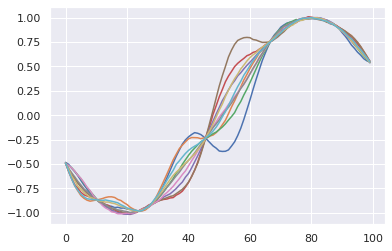

In [23]:
sns.set()
plt.plot(f_post)